In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import torch
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import diags
from scipy.sparse import eye
from pathlib import Path
from functools import partial
import networkx as nx
from sklearn.decomposition import PCA



In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

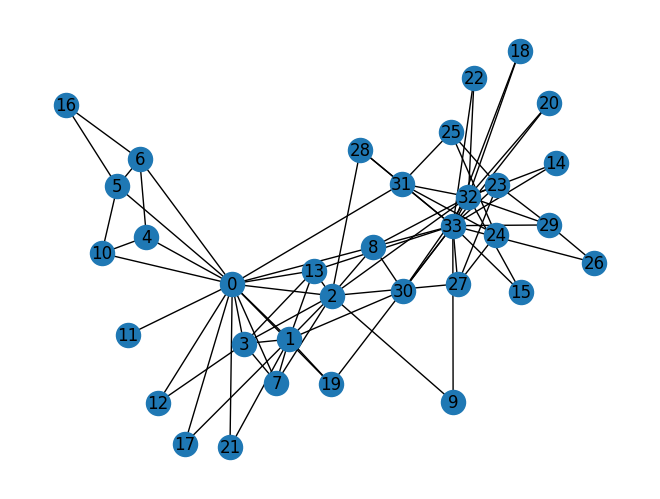

In [3]:
G = nx.karate_club_graph()
nx.draw(G, with_labels = True)

In [4]:
num_nodes = G.number_of_nodes()
embs = nn.Embedding(num_embeddings=num_nodes, embedding_dim=128)
num_nodes
# Find the connected components
connected_components = list(nx.connected_components(G))
print(connected_components)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]


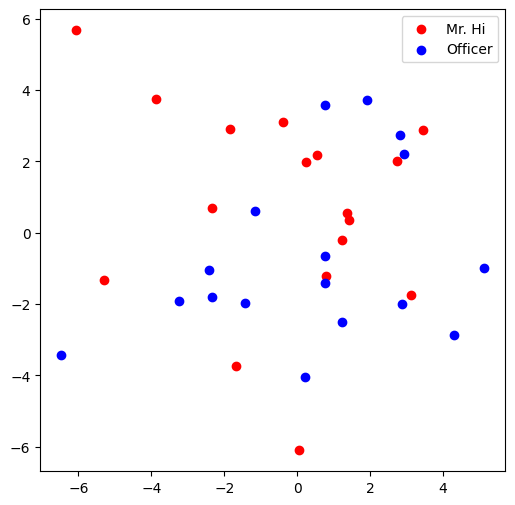

In [5]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(embs)

In [6]:
edges = np.asarray(list(G.edges()))
#edges

In [7]:
adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                 shape=(num_nodes, num_nodes), dtype=np.float32)

adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [8]:
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [9]:
nn.init.normal_(embs.weight, std=0.1)

Parameter containing:
tensor([[-0.0444,  0.0221,  0.0148,  ...,  0.2769, -0.1020,  0.0333],
        [ 0.0410, -0.0226,  0.2277,  ...,  0.1708, -0.1221, -0.0096],
        [ 0.0380, -0.1057,  0.1482,  ...,  0.0818,  0.1251, -0.0555],
        ...,
        [-0.0833, -0.0738,  0.0527,  ...,  0.0130,  0.1412,  0.0686],
        [ 0.1298, -0.1072, -0.0927,  ..., -0.0598,  0.0820, -0.1629],
        [ 0.0317,  0.0892, -0.1791,  ..., -0.0214, -0.0485,  0.0339]],
       requires_grad=True)

In [10]:
adj = normalize(adj + eye(adj.shape[0])) #Normalizing for removing gradient vanishing and exploding problem

In [11]:
np.random.seed(34)
# num_links is not a correct term!
num_links = 561
n_train = 460
n_val = 101
n_test = num_links - n_train - n_val
idxs = np.random.permutation(num_links)
idx_train = torch.LongTensor(idxs[:n_train])
idx_val   = torch.LongTensor(idxs[n_train:n_train+n_val])
idx_test  = torch.LongTensor(idxs[n_train+n_val:])

In [12]:
# Prepare positive and negative edges for link prediction, create corresponding labels, and combine them for training

pos_edge_list = edges
pos_edge_index = torch.tensor(pos_edge_list, dtype=torch.long).t().contiguous()
# Convert pos_edge_list to a set of tuples for efficient lookup
pos_edge_set = set((i, j) for i, j in pos_edge_list)

neg_edge_list = []
for i in range(num_nodes - 1):
    for j in range(i + 1, num_nodes):
      if(not (i, j) in pos_edge_set):
        neg_edge_list.append((i,j))

neg_edge_index = torch.tensor(neg_edge_list, dtype=torch.long).t().contiguous()
print(pos_edge_index.shape)
print(neg_edge_index.shape)

pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )
train_label = torch.cat([pos_label, neg_label], dim=0)

train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)


torch.Size([2, 78])
torch.Size([2, 483])


In [13]:
adj = torch.FloatTensor(adj.todense())
labels = train_label.long()

In [14]:
adj = adj.to(device)
embs = embs.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

In [15]:
class GraphConvolution(Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ') '

class GCN(nn.Module):
    def __init__(self, num_layers, train_edge, embs, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.embedding = Parameter(embs)
        self.train_edge = train_edge
        self.train_label = train_label
        self.num_layers = num_layers
        self.sigmoid = nn.Sigmoid()
        self.gc1 = GraphConvolution(nfeat, nclass)
        # self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout


    def forward(self, adj):
        x = self.embedding
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        # x = self.gc2(x, adj)

        emb_nodes = x[train_edge]
        vector1 = emb_nodes[0]
        vector2 = emb_nodes[1]
        vector2_transposed = vector2.transpose(0, 1)
        dot_product_matrix = torch.matmul(vector1, vector2_transposed)
        dot_product = torch.diagonal(dot_product_matrix).squeeze()
        pred = self.sigmoid(dot_product)
        pred = pred.squeeze()

        return pred

In [16]:
n_labels = labels.max().item() + 1
n_nodes = len(labels)
n_labels

2

In [17]:
torch.manual_seed(34)

model = GCN(num_layers=2,
            train_edge=train_edge,
            embs=embs.weight.detach(),
            nfeat=128,
            nhid=128,
            nclass=128,
            dropout=0.5)
optimizer = optim.Adam(model.parameters(),
                       lr=0.001, weight_decay=5e-4)


model = model.to(device)
loss_fn = nn.BCELoss()

def step():
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(adj)
    float_labels = labels.float()
    loss = loss_fn(output[idx_train], float_labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    return loss.item(), acc

def evaluate(idx):
    model.eval()
    output = model(adj)
    float_labels = labels.float()
    loss = loss_fn(output[idx], float_labels[idx])
    acc = accuracy(output[idx], float_labels[idx])

    return loss.item(), acc

In [18]:
def accuracy(output, labels):
    rounded_preds = torch.round(output)
    correct = (rounded_preds == labels).float()
    accu = correct.sum() / len(correct)
    return round(accu.item(), 4)

In [19]:
epochs = 2000
print_steps = 100
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for i in tqdm(range(epochs)):
    tl, ta = step()
    train_loss += [tl]
    train_acc += [ta]

    if((i+1)%print_steps) == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]

        print('Epochs: {}, Train Loss: {:.3f}, Train Acc: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}'.format(i, tl, ta, vl, va))

  1%|          | 22/2000 [00:03<03:59,  8.25it/s] 

Epochs: 0, Train Loss: 0.741, Train Acc: 0.139, Validation Loss: 0.742, Validation Acc: 0.139


  6%|▌         | 120/2000 [00:04<00:23, 79.52it/s]

Epochs: 99, Train Loss: 0.693, Train Acc: 0.607, Validation Loss: 0.693, Validation Acc: 0.564


 11%|█         | 220/2000 [00:04<00:12, 146.36it/s]

Epochs: 199, Train Loss: 0.693, Train Acc: 0.444, Validation Loss: 0.693, Validation Acc: 0.436


 17%|█▋        | 348/2000 [00:05<00:06, 272.75it/s]

Epochs: 299, Train Loss: 0.693, Train Acc: 0.424, Validation Loss: 0.693, Validation Acc: 0.426


 22%|██▏       | 440/2000 [00:05<00:05, 268.97it/s]

Epochs: 399, Train Loss: 0.693, Train Acc: 0.565, Validation Loss: 0.693, Validation Acc: 0.624


 28%|██▊       | 550/2000 [00:06<00:04, 331.53it/s]

Epochs: 499, Train Loss: 0.693, Train Acc: 0.646, Validation Loss: 0.693, Validation Acc: 0.713


 33%|███▎      | 653/2000 [00:06<00:04, 293.56it/s]

Epochs: 599, Train Loss: 0.693, Train Acc: 0.707, Validation Loss: 0.693, Validation Acc: 0.762


 37%|███▋      | 742/2000 [00:06<00:04, 257.24it/s]

Epochs: 699, Train Loss: 0.693, Train Acc: 0.752, Validation Loss: 0.693, Validation Acc: 0.792


 42%|████▏     | 837/2000 [00:07<00:03, 295.00it/s]

Epochs: 799, Train Loss: 0.693, Train Acc: 0.756, Validation Loss: 0.693, Validation Acc: 0.762


 46%|████▋     | 926/2000 [00:07<00:04, 217.43it/s]

Epochs: 899, Train Loss: 0.693, Train Acc: 0.754, Validation Loss: 0.693, Validation Acc: 0.762


 53%|█████▎    | 1051/2000 [00:08<00:04, 230.54it/s]

Epochs: 999, Train Loss: 0.693, Train Acc: 0.765, Validation Loss: 0.693, Validation Acc: 0.743


 56%|█████▋    | 1127/2000 [00:08<00:03, 236.42it/s]

Epochs: 1099, Train Loss: 0.693, Train Acc: 0.754, Validation Loss: 0.693, Validation Acc: 0.782


 62%|██████▏   | 1238/2000 [00:08<00:02, 255.50it/s]

Epochs: 1199, Train Loss: 0.683, Train Acc: 0.846, Validation Loss: 0.675, Validation Acc: 0.852


 66%|██████▌   | 1320/2000 [00:09<00:03, 224.88it/s]

Epochs: 1299, Train Loss: 0.682, Train Acc: 0.852, Validation Loss: 0.676, Validation Acc: 0.852


 71%|███████   | 1413/2000 [00:09<00:03, 178.93it/s]

Epochs: 1399, Train Loss: 0.682, Train Acc: 0.861, Validation Loss: 0.675, Validation Acc: 0.832


 77%|███████▋  | 1537/2000 [00:10<00:03, 153.57it/s]

Epochs: 1499, Train Loss: 0.682, Train Acc: 0.874, Validation Loss: 0.676, Validation Acc: 0.881


 81%|████████  | 1623/2000 [00:11<00:02, 163.08it/s]

Epochs: 1599, Train Loss: 0.682, Train Acc: 0.870, Validation Loss: 0.676, Validation Acc: 0.861


 86%|████████▋ | 1730/2000 [00:11<00:01, 160.43it/s]

Epochs: 1699, Train Loss: 0.682, Train Acc: 0.874, Validation Loss: 0.675, Validation Acc: 0.881


 91%|█████████▏| 1825/2000 [00:12<00:01, 156.01it/s]

Epochs: 1799, Train Loss: 0.682, Train Acc: 0.865, Validation Loss: 0.675, Validation Acc: 0.881


 96%|█████████▌| 1921/2000 [00:13<00:00, 179.60it/s]

Epochs: 1899, Train Loss: 0.683, Train Acc: 0.850, Validation Loss: 0.675, Validation Acc: 0.881


100%|██████████| 2000/2000 [00:13<00:00, 147.25it/s]

Epochs: 1999, Train Loss: 0.683, Train Acc: 0.857, Validation Loss: 0.675, Validation Acc: 0.881


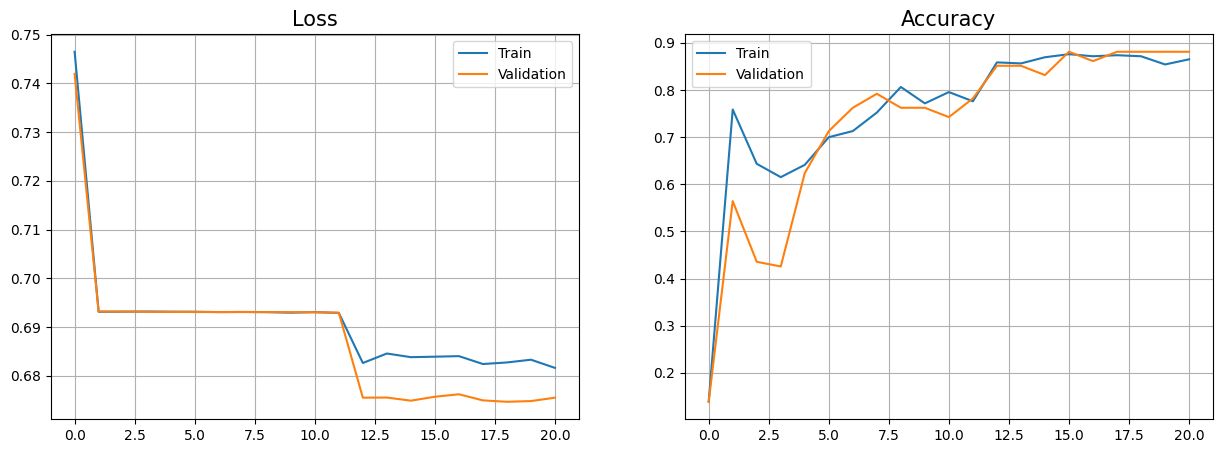

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
train_acc_cpu = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in train_acc]
val_acc_cpu = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in val_acc]
axes[1].plot(train_acc_cpu[::print_steps] + [train_acc_cpu[-1]], label='Train')
axes[1].plot(val_acc_cpu, label='Validation')
axes[0].grid()
axes[1].grid()

for ax, t in zip(axes, ['Loss','Accuracy']):
    ax.legend(), ax.set_title(t, size=15)

In [21]:
output = model(adj)

In [22]:
samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v:k for k,v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
df

NameError: name 'lbl2idx' is not defined

notes

1. number of layers was defined fixed
2. GCN arguments are not precise
3. dropout has been eliminated
4. could not we use dropout in linkGCN?